## Introduction

Let’s dive into one of the most exciting frontiers of machine learning in biology: large language models (LLMs), also known as foundation models.

In the biological domain, LLMs can be pre-trained on vast amounts of unlabeled sequences—such as DNA, RNA, or proteins—to learn rich, general-purpose representations known as embeddings. These embeddings capture biological patterns and structures, making them useful for a wide range of downstream tasks. For new sequences, we can either extract embeddings directly or fine-tune the model to produce task-specific representations.

In this tutorial, we’ll explore how to use pretrained biological LLMs to extract embeddings from different types of sequences. We'll look at several models across biological modalities:

- DNABERT2 for DNA sequences
- RNA-FM for RNA sequences
- Enformer for long DNA sequences
- ESM for protein sequences

Curious about what you can do with these embeddings? In upcoming tutorials, we'll show how to apply them to:

- Supervised learning: train models for tasks like regression or classification
- Unsupervised learning: use techniques like clustering or dimensionality reduction to explore patterns in the data

### 1. DNABERT2

DNABERT2 is a transformer-based language model designed specifically for DNA sequences. It builds on the architecture of BERT (Bidirectional Encoder Representations from Transformers), adapting it to the unique characteristics of genomic data.

Instead of using words like natural language models, DNABERT2 tokenizes DNA sequences into short overlapping k-mers (e.g. 6-mers like ATCGTA). By learning the patterns and context of these k-mers across massive amounts of unlabeled genome data, DNABERT2 is able to capture meaningful representations of DNA sequence elements such as promoters, enhancers, and motifs.

The following code are from the original DNABERT2 site https://github.com/MAGICS-LAB/DNABERT_2.


In [1]:
import torch
from transformers import AutoTokenizer, AutoModel
from torch import inf
from transformers.models.bert.configuration_bert import BertConfig
tokenizer = AutoTokenizer.from_pretrained("zhihan1996/DNABERT-2-117M", trust_remote_code=True)
config = BertConfig.from_pretrained("zhihan1996/DNABERT-2-117M")
model = AutoModel.from_pretrained("zhihan1996/DNABERT-2-117M", trust_remote_code=True, config=config)

/opt/homebrew/Caskroom/miniconda/base/envs/BioML-tut-llm/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


[2025-05-26 14:21:05,128] [INFO] [real_accelerator.py:239:get_accelerator] Setting ds_accelerator to mps (auto detect)


W0526 14:21:05.530000 25893 site-packages/torch/distributed/elastic/multiprocessing/redirects.py:29] NOTE: Redirects are currently not supported in Windows or MacOs.
/Users/yuxinshen/.cache/huggingface/modules/transformers_modules/zhihan1996/DNABERT-2-117M/d064dece8a8b41d9fb8729fbe3435278786931f1/bert_layers.py:126: UserWarning: Unable to import Triton; defaulting MosaicBERT attention implementation to pytorch (this will reduce throughput when using this model).
  warnings.warn(
Some weights of BertModel were not initialized from the model checkpoint at zhihan1996/DNABERT-2-117M and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [2]:
dna = "ACGTAGCATCGGATCTATCTATCGACACTTGGTTATCGATCTACGAGCATCTCGTTAGC"
inputs = tokenizer(dna, return_tensors = 'pt')["input_ids"]
hidden_states = model(inputs)[0] # [1, sequence_length, 768]

# embedding with mean pooling
embedding_mean = torch.mean(hidden_states[0], dim=0)
print(embedding_mean.shape) # expect to be 768

# embedding with max pooling
embedding_max = torch.max(hidden_states[0], dim=0)[0]
print(embedding_max.shape) # expect to be 768

torch.Size([768])
torch.Size([768])


Pooling: a technique used to reduce the dimensionality of a sequence of embeddings by summarizing them into a single, fixed-size vector. It's especially important when working with transformer models like BERT, which output a sequence of embeddings (one for each token or k-mer), but many downstream tasks (like classification or regression) expect a single vector as input.

We may also want to evaluate a batch of sequence. To achieve this, we set padding = True, truncation = True in the tokenizer.

Also small modifications to the pooling step:

In [5]:
# batch evaluation 
dna = ["ACGTAGCATCGGATCTATCTATCGACACTTGGTTATCGATCTACGAGCATCTCGTTAGC","ACGTAGCATCGGGTCTATCTATCGACACTTGGTTATCGATCTACGAGCATCTCGTTAGC"]
inputs = tokenizer(dna, return_tensors = 'pt', padding = True, truncation = True)["input_ids"]
hidden_states = model(inputs)[0] # [2, sequence_length, 768]

embedding_mean = torch.mean(hidden_states, dim=1)  # shape: [batch_size, 768]
embedding_max = torch.max(hidden_states, dim=1)[0] # shape: [batch_size, 768]
print(embedding_mean.shape)  # should print: torch.Size([2, 768])
print(embedding_max.shape)   # should print: torch.Size([2, 768])

torch.Size([2, 768])
torch.Size([2, 768])


Downstream tasks of the DNABERT2 model include Genome Understanding Evaluation (GUE), showing its capacity on Epigenetic Marks Prediction (EMP), Transcription Factor Prediction on the Human genome and the Mouse genome (TF-H and TF-M), Covid Variants Classification (CVC), Promoter Detection (PD), Core Promoter Detection (CPD), and Splice Site Prediction (SSP).

### 2. RNA-FM

RNA-FM (RNA Foundation Model) is a transformer-based language model specifically designed for RNA sequences. Developed to advance RNA research, RNA-FM captures intricate structural and functional information from RNA sequences, facilitating a wide range of downstream applications.
The following code are from the original RNA-FM site https://github.com/ml4bio/RNA-FM.

#### (1) On non-coding RNAs

In [ ]:
import torch
import fm

# 1. Load RNA-FM model
model, alphabet = fm.pretrained.rna_fm_t12()
batch_converter = alphabet.get_batch_converter()
model.eval()  # disables dropout for deterministic results

# 2. Prepare data
data = [
    ("RNA1", "GGGUGCGAUCAUACCAGCACUAAUGCCCUCCUGGGAAGUCCUCGUGUUGCACCCCU"),
    ("RNA2", "GGGUGUCGCUCAGUUGGUAGAGUGCUUGCCUGGCAUGCAAGAAACCUUGGUUCAAUCCCCAGCACUGCA"),
    ("RNA3", "CGAUUCNCGUUCCC--CCGCCUCCA"),
]
batch_labels, batch_strs, batch_tokens = batch_converter(data)

# 3. Extract embeddings (on CPU)
with torch.no_grad():
    results = model(batch_tokens, repr_layers=[12])
token_embeddings = results["representations"][12]

In [4]:
token_embeddings

tensor([[[-0.1326,  0.1063,  0.0631,  ...,  0.0964, -0.2054,  0.0271],
         [ 0.0998, -0.4092,  0.1103,  ..., -0.4704, -0.0205, -0.2949],
         [ 0.2168, -0.1919, -0.0448,  ..., -0.4306, -0.0160, -0.3249],
         ...,
         [-0.1390,  0.1097, -0.1074,  ..., -0.1592,  0.1676,  0.1030],
         [-0.1390,  0.1097, -0.1074,  ..., -0.1592,  0.1676,  0.1030],
         [-0.1390,  0.1097, -0.1074,  ..., -0.1592,  0.1676,  0.1030]],

        [[-0.1842, -0.0591, -0.1665,  ..., -0.0380, -0.0621,  0.1512],
         [ 0.0615, -0.6390,  0.0834,  ..., -0.5313,  0.2606, -0.3980],
         [ 0.1390, -0.4602,  0.0823,  ..., -0.6763,  0.1559, -0.5889],
         ...,
         [-0.2537, -0.1714,  0.0618,  ..., -0.0177,  0.1257, -0.1193],
         [ 0.2016, -0.0698, -0.2902,  ..., -0.1824,  0.6457, -0.0714],
         [-0.0364,  0.1553, -0.3325,  ..., -0.1311,  0.2662, -0.2012]],

        [[-0.0182,  0.1412,  0.0337,  ..., -0.0687, -0.0864,  0.0124],
         [-0.0204,  0.0278,  0.1148,  ..., -0

#### (2) Messenger RNAs

In [ ]:
import torch
import fm

# 1. Load mRNA-FM model
model, alphabet = fm.pretrained.mrna_fm_t12()
batch_converter = alphabet.get_batch_converter()
model.eval()  # disables dropout for deterministic results

# 2. Prepare data
data = [
    ("CDS1", "AUGGGGUGCGAUCAUACCAGCACUAAUGCCCUCCUGGGAAGUCCUCGUGUUGCACCCCUA"),
    ("CDS2", "AUGGGGUGUCGCUCAGUUGGUAGAGUGCUUGCCUGGCAUGCAAGAAACCUUGGUUCAAUCCCCAGCACUGCA"),
    ("CDS3", "AUGCGAUUCNCGUUCCC--CCGCCUCC"),
]
batch_labels, batch_strs, batch_tokens = batch_converter(data)

# 3. Extract embeddings (on CPU)
with torch.no_grad():
    results = model(batch_tokens, repr_layers=[12])
token_embeddings = results["representations"][12]

Downstream application of the RNA-FM embeddings are: RNA 3D Structure Prediction, RNA Design & Inverse Folding, Functional Annotation & Subcellular Localisation and RNA–Protein Interaction Prediction. For mRNA sequences, mRNA expression modelling and CDS analysis are also important downstream tasks.

### 3. Enformer

Enformer is a deep learning model developed by DeepMind that predicts gene expression directly from DNA sequences by capturing long-range interactions within the genome. Traditional models often consider only short genomic regions, limiting their ability to account for distant regulatory elements. Enformer overcomes this by effectively integrating information from sequences up to 100 kilobases away, enhancing the accuracy of gene expression predictions. The original enformer model is on https://github.com/google-deepmind/deepmind-research/tree/master/enformer, and the following code are from a site with pytorch implementation https://github.com/lucidrains/enformer-pytorch.

In [6]:
import torch
from enformer_pytorch import Enformer

model = Enformer.from_hparams(
    dim = 1536,
    depth = 11,
    heads = 8,
    output_heads = dict(human = 5313, mouse = 1643),
    target_length = 896,
)
    
seq = torch.randint(0, 5, (1, 196_608)) # for ACGTN, in that order (-1 for padding)
output = model(seq)

output['human'] # (1, 896, 5313)
output['mouse'] # (1, 896, 1643)

tensor([[[0.6423, 0.6172, 0.6926,  ..., 0.7323, 0.7333, 0.6455],
         [0.5064, 0.5703, 0.7153,  ..., 0.8689, 0.6061, 0.7101],
         [0.5595, 0.5919, 0.7143,  ..., 0.6849, 0.6365, 0.5883],
         ...,
         [0.6018, 0.7287, 0.6404,  ..., 0.7504, 0.7140, 0.8141],
         [0.5448, 0.6537, 0.7200,  ..., 0.7633, 0.6844, 0.6477],
         [0.5827, 0.7003, 0.6478,  ..., 0.7506, 0.7596, 0.7447]]],
       grad_fn=<SoftplusBackward0>)

In [ ]:
# get both output and embeddings
import torch
from enformer_pytorch import Enformer, seq_indices_to_one_hot

model = Enformer.from_hparams(
    dim = 1536,
    depth = 11,
    heads = 8,
    output_heads = dict(human = 5313, mouse = 1643),
    target_length = 896,
)

seq = torch.randint(0, 5, (1, 196_608))
one_hot = seq_indices_to_one_hot(seq)

output, embeddings = model(one_hot, return_embeddings = True)

embeddings # (1, 896, 3072)

tensor([[[ 0.5999, -0.0856,  0.1041,  ..., -0.0917,  0.0656,  0.2187],
         [ 0.0463, -0.0638, -0.1436,  ...,  0.0805,  0.1308,  0.0803],
         [-0.1374, -0.1493,  0.1777,  ..., -0.0347,  0.0000, -0.1619],
         ...,
         [-0.0898, -0.0337, -0.1073,  ..., -0.1367,  1.3286,  0.0030],
         [-0.1608,  0.2435,  0.0746,  ...,  0.1847, -0.1158, -0.1358],
         [ 0.1997,  0.0186,  0.2148,  ..., -0.1069,  0.7879,  0.0567]]],
       grad_fn=<MulBackward0>)

- Embeddings: These are the internal representations generated by the model, capturing complex features and long-range interactions within the input DNA sequence.They are typically extracted from the deeper layers of the model and can be used for various downstream analyses or tasks.
- Outputs: These are the final predictions made by the model, tailored to specific tasks such as predicting gene expression levels or chromatin states.The outputs are derived from the embeddings and are shaped according to the requirements of the prediction task.

Downstream application of the enformer model are: enhancer prediction, variant effect prediction on eQTL data and MPRA mutation effect prediction.

### 4. ESM

ESM-2 is a state-of-the-art protein model trained on a masked language modelling objective. The following code are from the original ESM site https://github.com/facebookresearch/esm.

In [ ]:
import torch
model, alphabet = torch.hub.load("facebookresearch/esm:main", "esm2_t33_650M_UR50D")

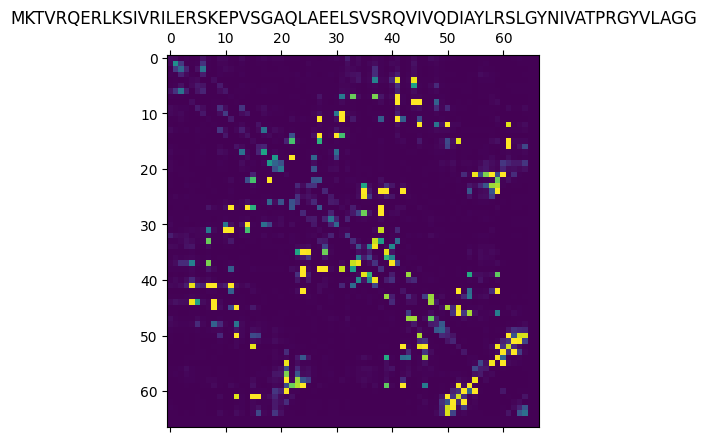

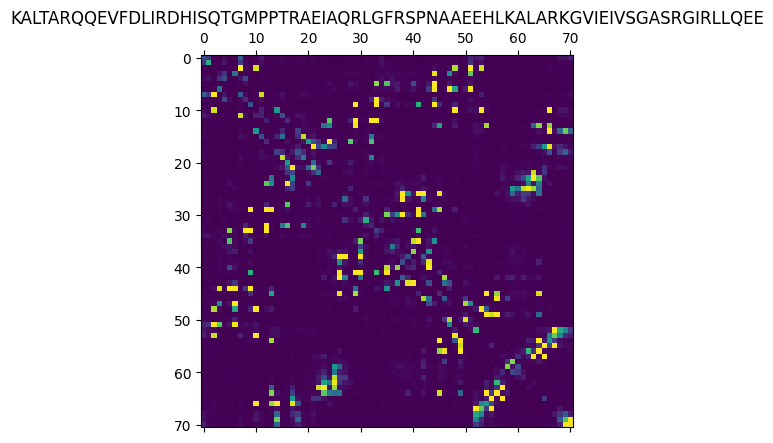

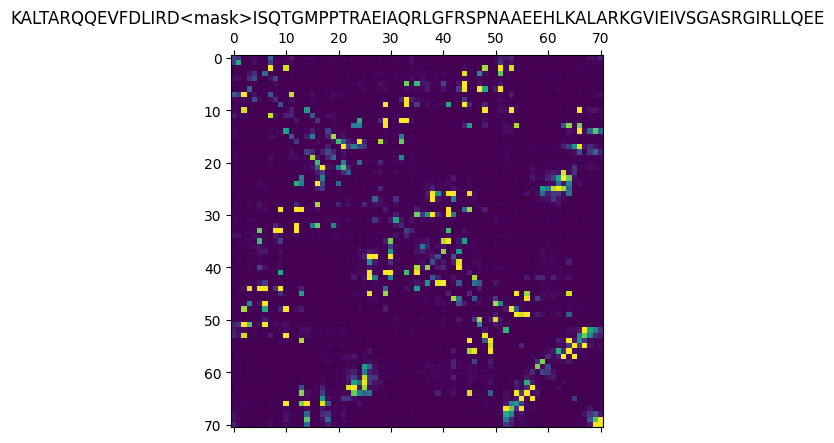

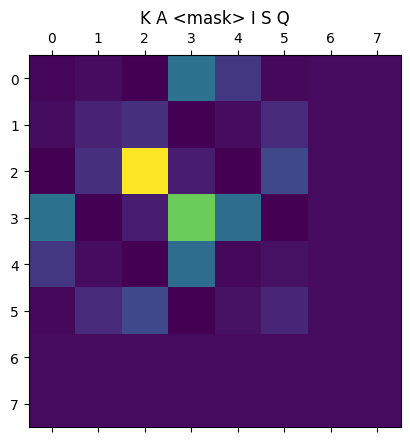

In [9]:
import torch
import esm

# Load ESM-2 model
model, alphabet = esm.pretrained.esm2_t33_650M_UR50D()
batch_converter = alphabet.get_batch_converter()
model.eval()  # disables dropout for deterministic results

# Prepare data (first 2 sequences from ESMStructuralSplitDataset superfamily / 4)
data = [
    ("protein1", "MKTVRQERLKSIVRILERSKEPVSGAQLAEELSVSRQVIVQDIAYLRSLGYNIVATPRGYVLAGG"),
    ("protein2", "KALTARQQEVFDLIRDHISQTGMPPTRAEIAQRLGFRSPNAAEEHLKALARKGVIEIVSGASRGIRLLQEE"),
    ("protein2 with mask","KALTARQQEVFDLIRD<mask>ISQTGMPPTRAEIAQRLGFRSPNAAEEHLKALARKGVIEIVSGASRGIRLLQEE"),
    ("protein3",  "K A <mask> I S Q"),
]
batch_labels, batch_strs, batch_tokens = batch_converter(data)
batch_lens = (batch_tokens != alphabet.padding_idx).sum(1)

# Extract per-residue representations (on CPU)
with torch.no_grad():
    results = model(batch_tokens, repr_layers=[33], return_contacts=True)
token_representations = results["representations"][33]

# Generate per-sequence representations via averaging
# NOTE: token 0 is always a beginning-of-sequence token, so the first residue is token 1.
sequence_representations = []
for i, tokens_len in enumerate(batch_lens):
    sequence_representations.append(token_representations[i, 1 : tokens_len - 1].mean(0))

# Look at the unsupervised self-attention map contact predictions
import matplotlib.pyplot as plt
for (_, seq), tokens_len, attention_contacts in zip(data, batch_lens, results["contacts"]):
    plt.matshow(attention_contacts[: tokens_len, : tokens_len])
    plt.title(seq)
    plt.show()

Downstream task includes protein folding, which is combined into the ESMFold pipeline. Fine-tuning of the model is also available at https://colab.research.google.com/github/huggingface/notebooks/blob/main/examples/protein_language_modeling.ipynb.